In [1]:
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import transforms

In [2]:
#PATH_TABULAR_DATA = "./drive/MyDrive/real_estate_price_prediction_processed_09042024.csv"
PATH_TABULAR_DATA = "./real_estate_price_prediction_processed_09042024.csv"


In [3]:
data_tab = pd.read_csv(PATH_TABULAR_DATA)

In [4]:
data_tab[["price_scaled"]] = MinMaxScaler().fit_transform(data_tab[["price"]])

In [5]:
data_tab.head()

,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors,price,price_scaled
0,35996577,0,43.643880,7.117183,8452,199,63.0,3.479524,3995.665362,205.385148,...,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,355000.0,0.145320
1,35811033,0,45.695757,4.895610,8234,3347,90.0,3.000000,3995.665362,223.000000,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,190000.0,0.072778
2,35731841,12,47.966791,-1.220451,5235,1650,61.0,3.479524,370.000000,205.385148,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39000.0,0.006390
3,35886765,12,47.289292,-1.878805,1929,2050,142.0,3.479524,764.000000,217.000000,...,8.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,299000.0,0.120699
4,35781137,0,45.718992,4.844234,4476,3334,88.0,3.000000,3995.665362,205.385148,...,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,478000.0,0.199397


In [6]:
X_train_, X_test, y_train_, y_test= train_test_split(
    data_tab.drop(columns=["price", "price_scaled"]),
    data_tab["price_scaled"],
    test_size=0.20,
    random_state=123,
    shuffle=True
    )

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_,
    y_train_,
    test_size=0.20,
    random_state=123,
    shuffle=True
    )

In [8]:
X_reorganized = pd.concat(
    [
        pd.DataFrame(X_train).assign(group="train"),
        pd.DataFrame(X_val).assign(group="val"),
        pd.DataFrame(X_test).assign(group="test")
    ]
).reset_index(drop=True)


y_reorganized = pd.concat(
    [
        pd.DataFrame(y_train).assign(group="train"),
        pd.DataFrame(y_val).assign(group="val"),
        pd.DataFrame(y_test).assign(group="test")
    ]
).reset_index(drop=True)

In [9]:
X_reorganized.sample(5)

,id_annonce,property_type,approximate_latitude,approximate_longitude,city,postal_code,size,floor,land_size,energy_performance_value,...,nb_boxes,nb_photos,has_a_balcony,nb_terraces,has_a_cellar,has_a_garage,has_air_conditioning,last_floor,upper_floors,group
371,36071049,0,45.809810,4.848647,1231,3357,67.0,2.000000,3995.665362,80.000000,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
6824,36011861,5,47.910551,1.901060,5515,2097,171.0,3.479524,180.000000,205.385148,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,train
35348,35881155,12,49.049022,2.098270,5950,4677,168.0,3.479524,494.000000,326.000000,...,0.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,test
11903,36014251,0,43.725123,4.803290,4731,516,8834.0,3.479524,130.000000,141.000000,...,0.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,train
12068,29477621,0,48.789343,2.505662,7003,4613,6212.0,2.000000,1088.000000,205.385148,...,0.0,14.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,train


In [10]:
#X_reorganized[["id_annonce", "group"]]

In [11]:
#PATH_IMAGES_DATA = "./drive/MyDrive/real_estate_price_prediction_metadata_images_09042024.csv"
PATH_IMAGES_DATA = "./real_estate_price_prediction_metadata_images_09042024.csv"

In [12]:
data_img = pd.read_csv(PATH_IMAGES_DATA)

In [13]:
data_img_agg = data_img.groupby('id_annonce')['long_path_image'].apply(list).reset_index(name='images')

In [14]:
data_img_groups = data_img_agg.merge(
    X_reorganized[["id_annonce", "group"]],
    how='left',
    on='id_annonce'
)

In [15]:
data_img_groups.sample(10)

,id_annonce,images,group
20846,35884929,[C:\Users\MI30743\github\bourbaki_challenges-m...,train
33973,36048729,[C:\Users\MI30743\github\bourbaki_challenges-m...,train
29224,36020013,[C:\Users\MI30743\github\bourbaki_challenges-m...,train
11856,35827375,[C:\Users\MI30743\github\bourbaki_challenges-m...,train
7025,35787257,[C:\Users\MI30743\github\bourbaki_challenges-m...,train
5267,35775939,[C:\Users\MI30743\github\bourbaki_challenges-m...,val
26234,35996517,[C:\Users\MI30743\github\bourbaki_challenges-m...,test
3445,35758327,[C:\Users\MI30743\github\bourbaki_challenges-m...,test
7225,35791179,[C:\Users\MI30743\github\bourbaki_challenges-m...,train
28665,36016401,[C:\Users\MI30743\github\bourbaki_challenges-m...,train


In [16]:
# Define the image transformation
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        ),
])


In [17]:
mapeo = {}
model_ = models.resnet152(pretrained=True)
model_layers = list(model_.children())[:-1]
model_feature_extract = torch.nn.Sequential(*model_layers)

def get_model_embedding(model_feature_extract, img_tensor):
    with torch.no_grad():
          # Get the image features from the ResNet-152 model
          img_features = model_feature_extract(img_tensor)
    return img_features

# for index in range(data_img_groups.shape[0]):

#   images_path = data_img_groups.iloc[index]["images"]

#   images_emmbeded = []

#   for path in images_path:
#     image = Image.open(path).convert("RGB")

#     image = preprocess(image).unsqueeze(0)

#     img_embedding = get_model_embedding(model_feature_extract, image)
#     images_emmbeded.append(img_embedding.flatten())

#   images_embbeding = torch.stack(images_emmbeded).mean(dim=0)

#   mapeo[index] = images_embbeding


c:\Users\MI30743\github\bourbaki_challenges-main\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MI30743\github\bourbaki_challenges-main\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
#data_img["long_path_image"]

In [19]:
import multiprocessing


def get_raw_embbeding(index):
    def get_model_embedding(model_feature_extract, img_tensor):
        with torch.no_grad():
            # Get the image features from the ResNet-152 model
            img_features = model_feature_extract(img_tensor)
        return img_features

    path = data_img.iloc[index]["long_path_image"]

    images_emmbeded = []

    image = Image.open(path).convert("RGB")

    image = preprocess(image).unsqueeze(0)

    img_embedding = get_model_embedding(model_feature_extract, image)

    return img_embedding.flatten()

def get_avg_embbeding(index):
    def get_model_embedding(model_feature_extract, img_tensor):
        with torch.no_grad():
            # Get the image features from the ResNet-152 model
            img_features = model_feature_extract(img_tensor)
        return img_features

    images_path = data_img_groups.iloc[index]["images"]

    images_emmbeded = []

    for path in images_path:
        image = Image.open(path).convert("RGB")

        image = preprocess(image).unsqueeze(0)

        img_embedding = get_model_embedding(model_feature_extract, image)
        images_emmbeded.append(img_embedding.flatten())

    images_embbeding = torch.stack(images_emmbeded).mean(dim=0)

    return images_embbeding

In [20]:
data_img.shape

(190699, 5)

In [21]:
#%%time
#out_ = map(get_raw_embbeding,list(range(100)))
#list(out_)

In [22]:
#%%time
#out_ = map(get_avg_embbeding, list(range(100)))
#list(out_)




In [23]:
#data_img_groups.shape

In [24]:
#pool_size = multiprocessing.cpu_count()

#pool_size

In [25]:
#%%time 
#results = [get_avg_embbeding(i) for i in range(100)]


In [26]:
#get_avg_embbeding(2)

In [27]:
#%%time
#def parallarel_procesing(numbers, pool_size):
#    pool = multiprocessing.Pool(pool_size)
#    results = pool.map(get_avg_embbeding, numbers)

#    return results

#index_images = range(2)#range(data_img_groups.shape[0])

#results = parallarel_procesing(index_images, pool_size)


In [28]:
#data_img_groups.shape[0]

In [29]:
#import json 

#mapeo_ = dict(zip(list(data_img_groups["id_annonce"].values), [ list(x.numpy()) for x in results]))

#with open("average_embbedings_images.json", "w") as outfile: 
#    json.dump(mapeo_, outfile)

In [30]:
class CustomDataset(Dataset):

    def __init__(
        self,
        data_features,
        data_target,
        data_img_groups,
        group='train',
        transform=None
        ) -> None:

        self.group = group

        self.data_features = data_features.query(
            f"group == '{self.group}'"
            )

        self.data_target = data_target.query(
            f"group == '{self.group}'"
            )

        self.data_img_groups = data_img_groups.query(
            f"group == '{self.group}'"
            )

        self.transform = transform

        self.model = models.resnet152(pretrained=True)
        self.model_layers = list(self.model.children())[:-1]
        self.model_feature_extract = torch.nn.Sequential(*self.model_layers)

        self.set_model_eval()

    def __len__(self):
        return len(self.data_features)

    def set_model_eval(self):
      """
      Set to evaluation model.
      """
      return self.model.eval()


    def get_model_embedding(self, img_tensor):

      with torch.no_grad():
          # Get the image features from the ResNet-152 model
          img_features = self.model_feature_extract(img_tensor)

      return img_features

    def load_image(self, path) -> Image.Image:

        return Image.open(path).convert("RGB")

    def __getitem__(self, index):

        images_path = self.data_img_groups.iloc[index]["images"]

        def _embbeding_images(path):
           
           image = self.load_image(path)
           
           if self.transform:
              image = self.transform(image).unsqueeze(0)

           img_embedding = self.get_model_embedding(image)     
           
           return img_embedding.flatten()

        images_emmbeded = list(map(_embbeding_images, images_path))

        # for path in images_path:
        #   image = self.load_image(path)

        #   if self.transform:
        #     image = self.transform(image).unsqueeze(0)

        #     img_embedding = self.get_model_embedding(image)
        #     images_emmbeded.append(img_embedding.flatten())

        images_embbeding = torch.stack(images_emmbeded).mean(dim=0)

        features = self.data_features.drop(
            columns=["id_annonce","group"]
            ).iloc[index,:]

        #features = torch.from_numpy(features).float()

        target = self.data_target[["price_scaled"]].values[index]

        avg_embbeding = images_embbeding
        tab_features = torch.tensor(features.values, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        return avg_embbeding, tab_features, target

In [31]:
train_dataset = CustomDataset(
        data_features=X_reorganized,
        data_target=y_reorganized,
        data_img_groups=data_img_groups,
        group='train',
        transform=preprocess
    )

val_dataset = CustomDataset(
        data_features=X_reorganized,
        data_target=y_reorganized,
        data_img_groups=data_img_groups,
        group='val',
        transform=preprocess
)

test_dataset = CustomDataset(
        data_features=X_reorganized,
        data_target=y_reorganized,
        data_img_groups=data_img_groups,
        group='test',
        transform=preprocess
)

c:\Users\MI30743\github\bourbaki_challenges-main\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MI30743\github\bourbaki_challenges-main\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\MI30743\github\bourbaki_challenges-main\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MI30743\github\bourbaki_challenges-main\.venv\L

In [32]:
BATCH_SIZE = 512

In [33]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [34]:
# Define the neural network
class PricePredictionModel(nn.Module):
    def __init__(self, embedding_size=2048, tabular_input_size=26):  # Adjust tabular_input_size based on your actual features
        super(PricePredictionModel, self).__init__()
        self.fc1 = nn.Linear(embedding_size+tabular_input_size, 512)  # Output a single value for price prediction
        self.fc2 = nn.Linear(512, 1)
        self.DO = nn.Dropout(p=0.4)

    def forward(self, image_inputs, tabular_inputs):
        combined_embedding = torch.cat((image_inputs, tabular_inputs), dim=1)
        output = self.DO(torch.relu(self.fc1(combined_embedding)))
        output = torch.relu(self.fc2(output))
        return output.squeeze(1)

In [35]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

In [36]:
device

'cuda:0'

In [37]:
#model = MultiModal(device=device)

In [38]:
# Initialize the model, loss, and optimizer
model = PricePredictionModel().to(device)

In [39]:
class EarlyStopping:
    def __init__(self, patience, verbose=False, delta=0, path="checkpoint.pt"):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        return self.early_stop

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(
                f"Validation Loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model to {self.path}"
            )
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

    def load_checkpoint(self, model):
        """Loads the best model weights from the saved checkpoint."""
        model.load_state_dict(torch.load(self.path))

In [40]:
# Tunners
LR = 0.01
EPOCHS = 1

In [41]:
optimizer = optim.Adam(model.parameters(), lr=LR, amsgrad=True, weight_decay=LR * 0.1)

criterion = nn.L1Loss().to(device) #nn.L1Loss().to(device)

early_stopping = EarlyStopping(patience=int(EPOCHS * 0.5), verbose=True)

In [42]:
def train_eval(model, loader, optimizer, loss_func, is_training):
    loss_list = []
    stop = False
    model.train() if is_training else model.eval()

    with torch.set_grad_enabled(is_training):  # Enable gradients only in training
        for batch_idx, (avg_embbeding, tab_features, target) in tqdm(
            enumerate(loader),
            desc="Epoch_Train" if is_training else "Epoch_Val",
            total=len(loader),
        ):
            avg_embbeding, tab_features, target = avg_embbeding.to(device), tab_features.to(device), target.to(device)

            if is_training:
                optimizer.zero_grad()  # Reset gradients
            output = model(avg_embbeding, tab_features)
            loss = loss_func(output, target.squeeze(1))

            if is_training:
                loss.backward()  # Compute gradients
                optimizer.step()  # Update weights

            loss_list.append(loss.item())

    if not is_training:
        stop = early_stopping(
            (sum(loss_list) / len(loss_list)), model
        )  # Early stopping decision

    return loss_list, stop

In [43]:
def calc_acc_loss(total_loss, loss):
    total_loss.append(sum(loss) / len(loss))
    return total_loss

In [44]:
# Lists
total_loss_train = []
total_loss_val = []

In [45]:
torch.cuda.empty_cache()
try:
  torch.cuda.reset_peak_memory_stats()
except:
  pass

In [46]:
%%time
# Training and Evaluation loop
for epoch in range(EPOCHS):
    # Train Iteration
    loss_train, _ = train_eval(
        model, train_loader, optimizer, criterion, is_training=True
    )

    # Val Iteration
    loss_val, stop = train_eval(
        model, val_loader, optimizer, criterion, is_training=False
    )

    # Calculate and record loss & accuracy for training and validation
    total_loss_train = calc_acc_loss(
        total_loss_train,
        loss_train
    )

    # Calculate Loss and Accuracy
    total_loss_val = calc_acc_loss(
        total_loss_val,
        loss_val
    )

    # Print metrics per epoch
    print(
        f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {total_loss_train[-1]:.4f}, Val Loss: {total_loss_val[-1]:.4f}"
    )

    if stop:
        print("Early Stopping")
        break

Epoch_Train:   0%|          | 0/47 [00:00<?, ?it/s]

Epoch_Val:   0%|          | 0/12 [00:00<?, ?it/s]

Validation Loss decreased (inf --> 0.138548). Saving model to checkpoint.pt
Epoch 1/1 - Train Loss: 0.1574, Val Loss: 0.1385
CPU times: total: 1d 9h 54min 8s
Wall time: 7h 35min 55s


## Testing

In [47]:
try:
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()
except:
  pass

In [48]:
model_pred = PricePredictionModel().to(device) #MultiModal(device=device)
model_pred.load_state_dict(torch.load("checkpoint.pt"))
model_pred.to(device)

PricePredictionModel(
  (fc1): Linear(in_features=2074, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (DO): Dropout(p=0.4, inplace=False)
)

In [49]:
def test(model, loader):
    model.eval()
    total_loss_test = []
    outputs_test = []
    target_test = []

    pred = torch.Tensor().to(device)

    with torch.no_grad():
        for batch_idx, (avg_embbeding, tab_features, target) in tqdm(
            enumerate(loader), desc="Test Epoch", total=len(loader)
        ):
            avg_embbeding, tab_features, target = avg_embbeding.to(device), tab_features.to(device), target.to(device)
            output = model(avg_embbeding, tab_features)

            outputs_test.append(output)
            target_test.append(target)

            loss = criterion(output, target.squeeze(1))
            total_loss_test.append(loss.item())

        outputs_test = torch.concat(outputs_test, dim=0).cpu().numpy()
        target_test = torch.concat(target_test, dim=0).cpu().numpy()

        return total_loss_test, outputs_test, target_test.squeeze()

In [50]:
total_loss_test, outputs_test, target_test = test(model_pred, test_loader)

Test Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

In [51]:
print(f"Loss Test: {(sum(total_loss_test) / len(total_loss_test)):.3f}")

Loss Test: 0.143


In [55]:
from sklearn.metrics import root_mean_squared_error, median_absolute_error

print("RMSE:", root_mean_squared_error(outputs_test, target_test))
print("median_absolute_error:", median_absolute_error(outputs_test, target_test))

RMSE: 0.19803348
median_absolute_error: 0.10350907


<Axes: >

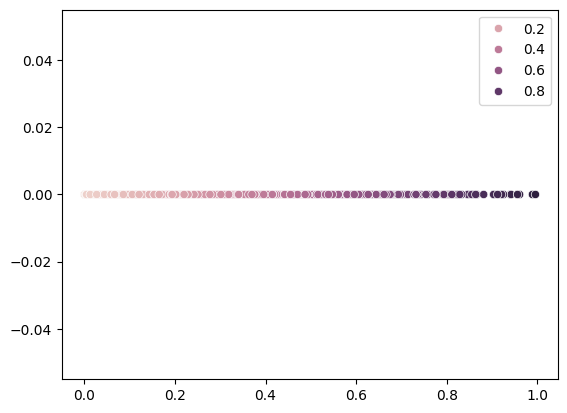

In [63]:
import seaborn as sns


sns.scatterplot(
    x = target_test,
    y = outputs_test.squeeze(),
    hue=target_test
    )